In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

(-0.5, 63.5, 63.5, -0.5)

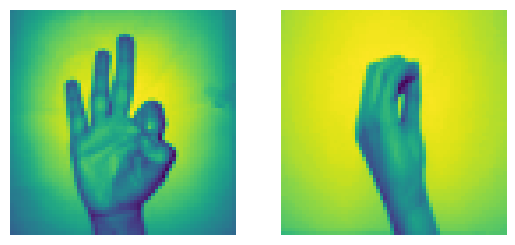

In [38]:
X = np.load("X.npy")
Y = np.load("Y.npy")
img_size = 64
plt.subplot(1,2,1)
plt.imshow(X[200].reshape(img_size,img_size))
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(X[400].reshape(img_size, img_size))
plt.axis("off")

In [39]:
X.shape

(2062, 64, 64)

In [40]:
x = np.concatenate((X[204:409], X[822:1027]), axis = 0)
Z = np.zeros(205)
o = np.ones(205)
y = np.concatenate((Z, o), axis = 0).reshape(x.shape[0],1)
print("x shape :", x.shape)
print("y shape :", y.shape)

x shape : (410, 64, 64)
y shape : (410, 1)


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]
print(number_of_train)
print(number_of_test)

348
62


In [42]:
#X_train.shape[1]   #64
#X_train.shape[2]   #64

In [43]:
X_train_flatten = X_train.reshape(number_of_train, X_train.shape[1] * X_train.shape[2])
X_test_flatten = X_test.reshape(number_of_test, X_test.shape[1] * X_test.shape[2])
print("X train flatten\n", X_train_flatten.shape)
print("\nX test flatten\n", X_test_flatten.shape)

X train flatten
 (348, 4096)

X test flatten
 (62, 4096)


In [44]:
#Matrisleri çarpabilmek için transpoz alma işlemi yaptık.
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train_t = y_train.T
y_test_t = y_test.T

print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train_t.shape)
print("y test: ",y_test_t.shape)

x train:  (4096, 348)
x test:  (4096, 62)
y train:  (1, 348)
y test:  (1, 62)


#### Initializing Parameters 

In [45]:
def dummy(parameter):
    dummy_parameter = parameter + 5
    return dummy_parameter
result = dummy(3)
print(result)

8


In [46]:
# dimension = 4096
def initialize_weights_and_bias(dimension):
    # 4096x1'lik bir matris oluşturacak bu matrisin içine 0.01 sayısını koyar.
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

#### Forward Propagation

In [47]:
# calculation of z
# z = np.dot(w.T, x_train) + b
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

In [48]:
#y_head = sigmoid(10)

In [49]:
#y_head

In [50]:
# Let's write forward propagation method

def forward_propagation(w,b,x_train,y_train):
    # np.dot() metodu sonuç olarak aldığı iki Numpy dizininin nokta çarpımı ya da bir diğer adıyla skaler çarpımını döndürür.
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)  # y_head 0 ve 1 arasında probabilistik bir değerdir.
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    return cost 

#### Backward Propagation

In [51]:
# Therefore instead of writing backward propagation method, lets combine forward propagation and backward propagation.
def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    # backward propagation
    # türev
    # x_train.shape[1] benim sample sayım. Bunu yaparak scale etmiş oluyoruz. Scale etmediğimiz zaman belli bir yere kadar 
    # değerlerimiz yüksek çıkacak.Scale etmek bu yüzden bizim için iyi olur.
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]                 # x_train.shape[1]  is for scaling
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    # dictionary şeklinde return ediyoruz.
    return cost,gradients

#### Update Parameters

In [52]:
# Updating (Learning) parameters
def update(w, b, x_train, y_train, learning_rate, number_of_iteration):
    
    # daha sonra görselleştirmede bize yardımcı olacak boş listelerimiz.
    cost_list = []
    cost_list2 = []
    index = []
    
    # updating(learning) parameters are number_of_iteration times
    for i in range(number_of_iteration):
        # make forward propagation and backward propagation and find cost and gradients
        cost, gradients = forward_backward_propagation(w, b, x_train, y_train)
        cost_list.append(cost)
        
        #lets update
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        
        if i % 10 == 0:
            cost_list2.append(cost)
            index.append(i)
            print("Cost after iteration %i : %f" %(i, cost))
        
    # we update(learn) parameters weights and bias
    parameters = {"weight" : w, "bias" : b}
    plt.plot(index, cost_list2)
    plt.xticks(index, rotation = 'vertical')
    plt.xlabel("Number of Iteration")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

#### Prediction

In [53]:
def predict(w,b, x_test):
    # x_test is a input for forward propagation
    z = sigmoid(np.dot(w.T, x_test) + b)
    Y_prediction = np.zeros((1, x_test.shape[1]))
    
    # THRESHOLD
    # if z is bigger than 0.5, our prediction is sign one (y_head = 1)
    # if z is smaller than 0.5, our prediction is sign zero (y_head = 0)
    for i in range(z.shape[1]):
        if z[0,i] <= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
    return Y_prediction

#### Logistic Regression

Cost after iteration 0 : 14.014222
Cost after iteration 10 : 2.544689
Cost after iteration 20 : 2.577950
Cost after iteration 30 : 2.397999
Cost after iteration 40 : 2.185019
Cost after iteration 50 : 1.968348
Cost after iteration 60 : 1.754195
Cost after iteration 70 : 1.535079
Cost after iteration 80 : 1.297567
Cost after iteration 90 : 1.031919
Cost after iteration 100 : 0.737019
Cost after iteration 110 : 0.441355
Cost after iteration 120 : 0.252278
Cost after iteration 130 : 0.205168
Cost after iteration 140 : 0.196168


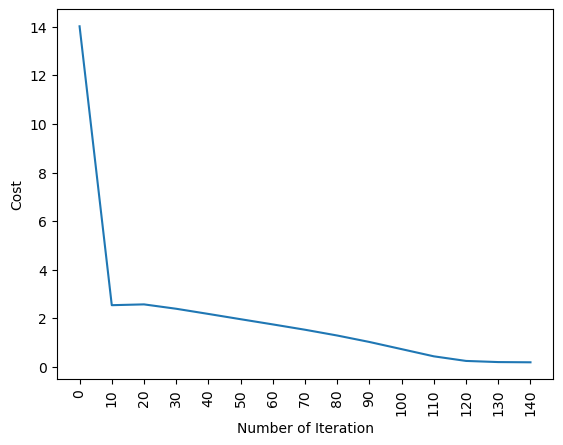

train accuracy : 92.816091954023 %
test accuracy : 93.54838709677419 %


In [54]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate, num_iterations):
    
    # initialize
    dimension = x_train.shape[0]  # 4096
    w, b = initialize_weights_and_bias(dimension)
    
    # don't change learning rate
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate, num_iterations)
    
    y_prediction_test = predict(parameters["weight"], parameters["bias"], x_test)
    y_prediction_train = predict(parameters["weight"], parameters["bias"], x_train)
    
    # print train / test Errors
    print("train accuracy : {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy : {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    
logistic_regression(x_train, y_train_t, x_test, y_test_t, learning_rate = 0.01, num_iterations = 150)

#### Logistic Regression with Sklearn

In [55]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(random_state=42, max_iter=150)
print('test accuracy : {}'.format(logreg.fit(x_train.T, y_train_t.T).score(x_test.T, y_test_t.T)))
print('train accuracy : {}'.format(logreg.fit(x_train.T, y_train_t.T).score(x_train.T, y_train_t.T)))

test accuracy : 0.967741935483871


C:\Users\aleyy\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aleyy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aleyy\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

train accuracy : 1.0


C:\Users\aleyy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Artificial Neural Network (ANN)

#### 2-Layer Neural Network

In [56]:
# Size of Layers and Initializing parameters weights and bias
def initialize_parameters_and_layer_sizes_NN(x_train, y_train):
    parameters = {'weight1' : np.random.randn(3, x_train.shape[0]) * 0.1,
                 'bias1' : np.zeros((3, 1)),
                 'weight2' : np.random.randn(y_train.shape[0], 3) * 0.1,
                 'bias2' : np.zeros((y_train.shape[0], 1))}
    return parameters

# weight1 * x_train (4096x1) = 3x1
# weight1 : 3x4096

# z[1] = w1 * X + b1
# A[1] = tanh(z[1])

# weight2 * A[1] = 1x1  -> output layer, tek node
# bias1 : 3x1
# weight2 : 1x3
# bias2 : 1x1

# z[2] = w2 * A[1] + b2
# A[2] = σ(z[2])

#### Forward Propagation

In [57]:
def forward_propagation_NN(x_train, parameters):
    Z1 = np.dot(parameters["weight1"], x_train) + parameters["bias1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(parameters["weight2"], A1) + parameters["bias2"]
    A2 = sigmoid(Z2)
    
    cache = {"Z1" : Z1,
             "A1" : A1,
             "Z2" : Z2,
             "A2" : A2}
    return A2, cache

#### Loss and Cost Function

In [58]:
# Compute cost
def compute_cost_NN(A2, Y, parameters):
    logprobs = np.multiply(np.log(A2),Y)
    cost = -np.sum(logprobs)/Y.shape[1]
    return cost

#### Backward Propagation

In [59]:
# weight ve bias değerlerini güncelleme yapabilmek için:
def backward_propagation_NN(parameters, cache, X, Y):
    dZ2 = cache["A2"] - Y
    dW2 = np.dot(dZ2, cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2, axis = 1, keepdims = True) / X.shape[1]
    dZ1 = np.dot(parameters["weight2"].T, dZ2) * (1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1, X.T) / X.shape[1]
    db1 = np.sum(dZ1, axis = 1, keepdims=True) / X.shape[1]
    
    grads = {"dweight1" : dW1,
             "dbias1" : db1,
             "dweight2" : dW2,
             "dbias2" : db2}
    return grads

#### Update Parameters

In [60]:
def update_parameters_NN(parameters, grads, learning_rate = 0.01):
    parameters = {'weight1' : parameters["weight1"] - learning_rate * grads["dweight1"],
                 'bias1' : parameters["bias1"] - learning_rate * grads["dbias1"],
                 'weight2' : parameters["weight2"] - learning_rate * grads["dweight2"],
                 'bias2' : parameters["bias2"] - learning_rate * grads["dbias2"]}
    return parameters

#### Prediction with learnt parameters weight and bias

In [61]:
def predict_NN(parameters, x_test):
    # x_test is a input for forward propagation
    A2, cache = forward_propagation_NN(x_test, parameters)
    Y_prediction = np.zeros((1, x_test.shape[1]))
    
    # if z is bigger than 0.5, our prediction is sign one (y_head = 1)
    # if z is smaller than 0.5, out prediction is sign zero (y_head = 0)
    for i in range(A2.shape[1]):
        if A2[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
            
    return Y_prediction

#### Create ANN Model

Cost after iteration 0: 0.391629
Cost after iteration 100: 0.343403
Cost after iteration 200: 0.297080
Cost after iteration 300: 0.251276
Cost after iteration 400: 0.211068
Cost after iteration 500: 0.180458
Cost after iteration 600: 0.197826
Cost after iteration 700: 0.159958
Cost after iteration 800: 0.121828
Cost after iteration 900: 0.106845
Cost after iteration 1000: 0.096698
Cost after iteration 1100: 0.088281
Cost after iteration 1200: 0.081117
Cost after iteration 1300: 0.074852
Cost after iteration 1400: 0.069410
Cost after iteration 1500: 0.064872
Cost after iteration 1600: 0.061125
Cost after iteration 1700: 0.057956
Cost after iteration 1800: 0.055115
Cost after iteration 1900: 0.052464
Cost after iteration 2000: 0.050017
Cost after iteration 2100: 0.047778
Cost after iteration 2200: 0.045691
Cost after iteration 2300: 0.043657
Cost after iteration 2400: 0.041514


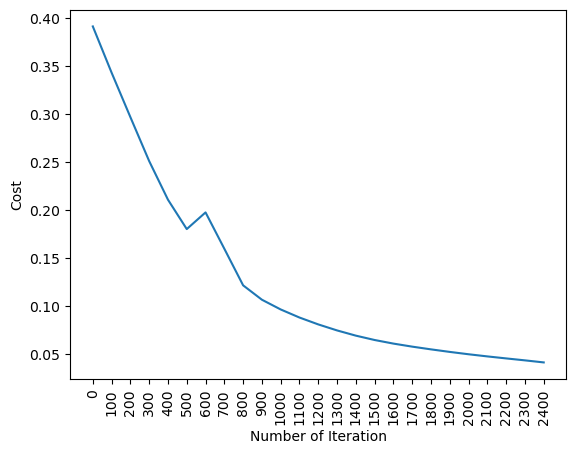

train accuracy : 99.42528735632185 %
test accuracy : 95.16129032258064 %


In [65]:
# 2-Layer neural network
def two_layer_neural_network(x_train, y_train, x_test, y_test, num_iterations):
    cost_list = []
    index_list = []
    
    # initialize parameters and layer sizes
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train)
    
    for i in range(0, num_iterations):
        
        # forward propagation
        A2, cache = forward_propagation_NN(x_train, parameters)
        
        # compute cost
        cost = compute_cost_NN(A2, y_train, parameters)
        
        # backward propagation
        grads = backward_propagation_NN(parameters, cache, x_train, y_train)
        
        # update parameters
        parameters = update_parameters_NN(parameters, grads)
        
        if i % 100 == 0:
            cost_list.append(cost)
            index_list.append(i)
            print("Cost after iteration %i: %f" %(i, cost))
    plt.plot(index_list, cost_list)
    plt.xticks(index_list, rotation="vertical")
    plt.xlabel("Number of Iteration")
    plt.ylabel("Cost")
    plt.show()
        
    # predict
    y_prediction_test = predict_NN(parameters, x_test)
    y_prediction_train = predict_NN(parameters, x_train)
        
    # print train/test Errors
    print("train accuracy : {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy : {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    return parameters
parameters = two_layer_neural_network(x_train, y_train_t, x_test, y_test_t, num_iterations=2500)
        

#### L-Layer Neural Network

In [68]:
# reshaping
x_train, x_test, y_train, y_test = x_train.T, x_test.T, y_train_t.T, y_test_t.T

#### Implementing with keras library

In [69]:
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential   # initialize neural network library
from keras.layers import Dense    # build our layers library

def build_classifier():
    classifier = Sequential()  # initialize neural network
    # there are 8 nodes in first hidden layer
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train.shape[1]))
    # there are 4 nodes in second hidden layer
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    # there are 1 node in third hidden layer and this is output layer
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, epochs = 100)
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 3)
mean = accuracies.mean()
variance = accuracies.std()
print('Accuracy mean: '+ str(mean))
print('Accuracy variance: '+ str(variance))

C:\Users\aleyy\AppData\Local\Temp\ipykernel_19208\598709212.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier, epochs = 100)


Epoch 1/100
8/8 [==============================] - 1s 2ms/step - loss: 0.6912 - accuracy: 0.5431
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.5431
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6860 - accuracy: 0.5431
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6845 - accuracy: 0.5431
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6822 - accuracy: 0.5431
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5431
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5431
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5431
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.5431
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.5431
Epoch 11/100
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.2306 - accuracy: 0.9698
Epoch 85/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2334 - accuracy: 0.9655
Epoch 86/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - accuracy: 0.9828
Epoch 87/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2272 - accuracy: 0.9698
Epoch 88/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2313 - accuracy: 0.9698
Epoch 89/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2375 - accuracy: 0.9698
Epoch 90/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2236 - accuracy: 0.9828
Epoch 91/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2228 - accuracy: 0.9741
Epoch 92/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2444 - accuracy: 0.9741
Epoch 93/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2395 - accuracy: 0.9741
Epoch 94/100
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0743 - accuracy: 0.9784
Epoch 67/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.9871
Epoch 68/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.9828
Epoch 69/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9914
Epoch 70/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0619 - accuracy: 0.9828
Epoch 71/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0640 - accuracy: 0.9828
Epoch 72/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1014 - accuracy: 0.9698
Epoch 73/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0857 - accuracy: 0.9698
Epoch 74/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9957
Epoch 75/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9741
Epoch 76/100
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5043
Epoch 49/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5043
Epoch 50/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5043
Epoch 51/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5043
Epoch 52/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5043
Epoch 53/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5043
Epoch 54/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5043
Epoch 55/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5043
Epoch 56/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5043
Epoch 57/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5043
Epoch 58/100
8/8 [===============

#### Neural network with Pytorch